In [37]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [38]:
!pip install --upgrade imutils
!pip install --upgrade dlib
!pip install --upgrade cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [39]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
!unzip -qo driver_drowsiness_detection_modified.zip

--2023-03-10 21:02:44--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/driver_drowsiness_detection_modified.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.66.4
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.66.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127436131 (122M) [application/x-zip-compressed]
Saving to: ‘driver_drowsiness_detection_modified.zip.2’

driver_drowsiness_d 100%[===================>] 121.53M  12.9MB/s    in 11s     

2023-03-10 21:02:56 (11.0 MB/s) - ‘driver_drowsiness_detection_modified.zip.2’ saved [127436131/127436131]



In [40]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


In [41]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print(X[0].shape)

1452
(32, 32, 3)


In [42]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [43]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [45]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


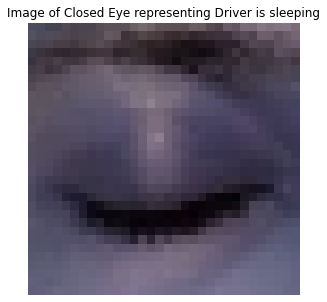

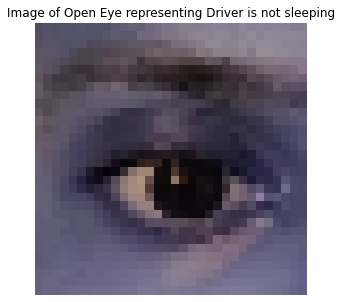

In [46]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


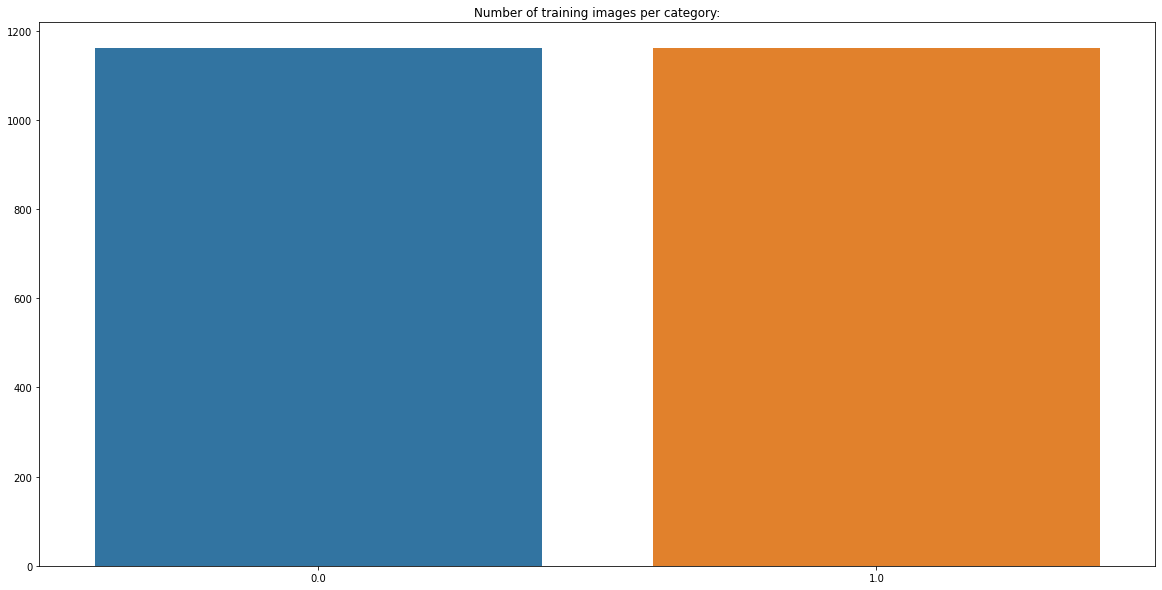

In [47]:
unique_train, count = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_train, count).set_title("Number of training images per category:")
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


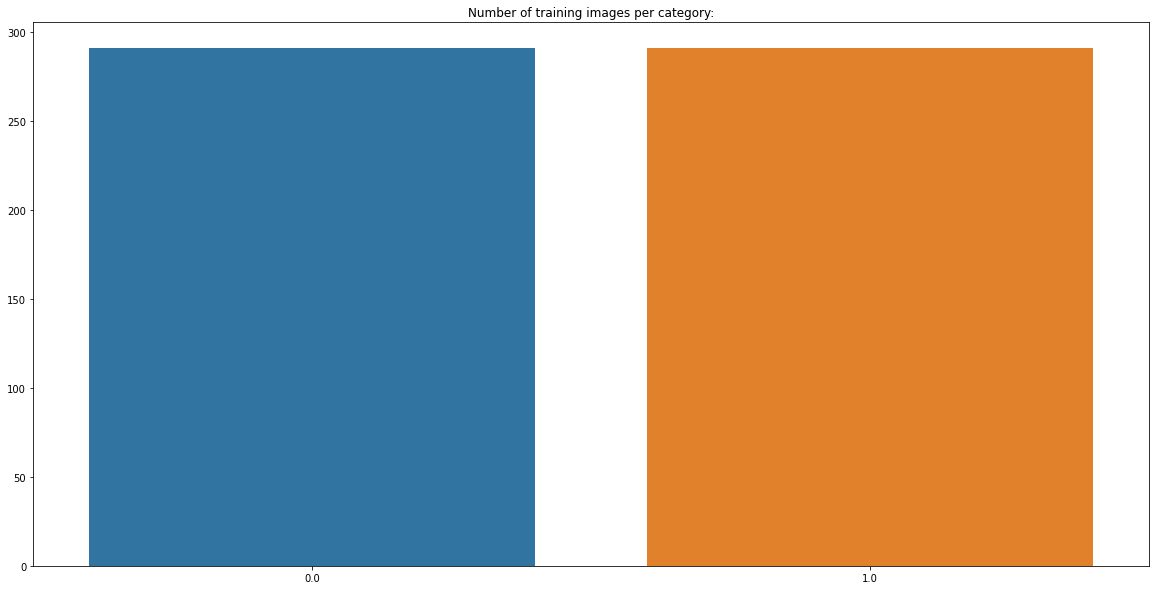

In [48]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_test, count_test).set_title("Number of training images per category:")
plt.show()

In [49]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)      

In [51]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=200, validation_data=(X_test, Y_test))

Epoch 1/200
10/10 [==============================] - 12s 889ms/step - loss: 1.3793 - accuracy: 0.5013 - val_loss: 0.7088 - val_accuracy: 0.5017
Epoch 2/200
10/10 [==============================] - 7s 762ms/step - loss: 1.1096 - accuracy: 0.5754 - val_loss: 0.6957 - val_accuracy: 0.5155
Epoch 3/200
10/10 [==============================] - 8s 767ms/step - loss: 1.0190 - accuracy: 0.5659 - val_loss: 0.6720 - val_accuracy: 0.5567
Epoch 4/200
10/10 [==============================] - 7s 693ms/step - loss: 0.9010 - accuracy: 0.5874 - val_loss: 0.6450 - val_accuracy: 0.5911
Epoch 5/200
10/10 [==============================] - 9s 948ms/step - loss: 0.8853 - accuracy: 0.6202 - val_loss: 0.6256 - val_accuracy: 0.6495
Epoch 6/200
10/10 [==============================] - 8s 830ms/step - loss: 0.8357 - accuracy: 0.6176 - val_loss: 0.6153 - val_accuracy: 0.6770
Epoch 7/200
10/10 [==============================] - 7s 708ms/step - loss: 0.8111 - accuracy: 0.6288 - val_loss: 0.6044 - val_accuracy: 0.735

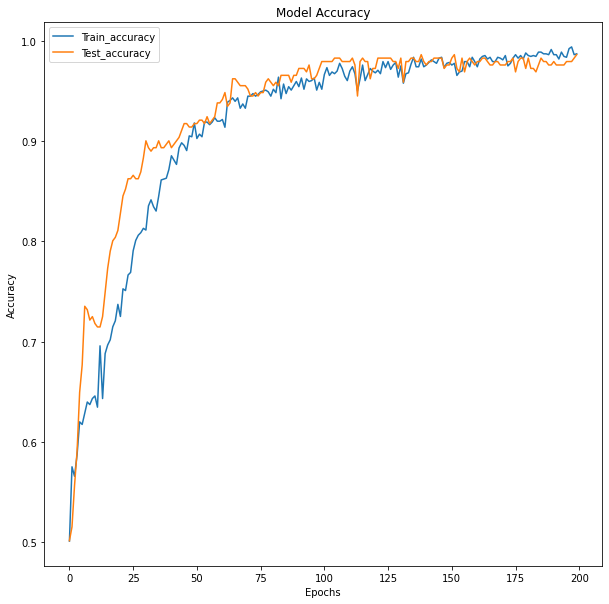

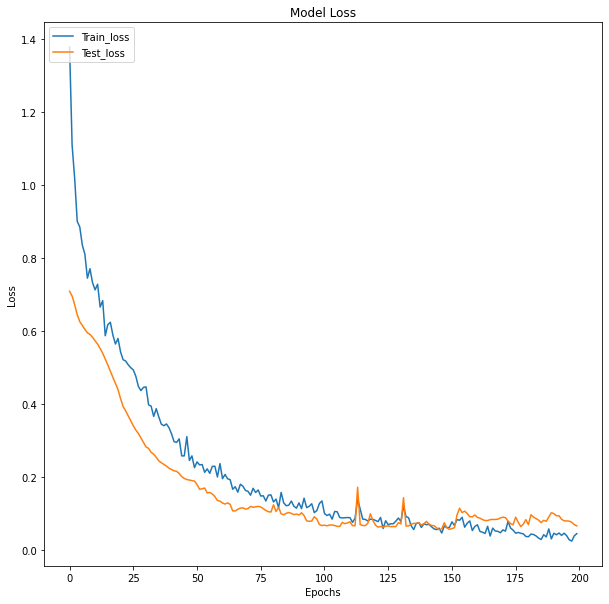

In [52]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [53]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 1s 107ms/step - loss: 0.0652 - accuracy: 0.9863
Test Set Accuracy: 0.9862542748451233
Test Set Loss: 0.06515602767467499


In [54]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

10/10 [==============================] - 1s 73ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       146
           1       0.99      0.98      0.99       145

    accuracy                           0.99       291
   macro avg       0.99      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



<AxesSubplot:>

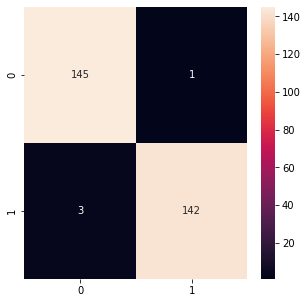

In [55]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [56]:
model.save('Driver_Drowsiness_Detection.h5')

In [57]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('driver_drowsiness_detection/closed_eye.jpg')
img_closed2 = cv2.imread('driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('driver_drowsiness_detection/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [58]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

1/1 [==============================] - 0s 44ms/step


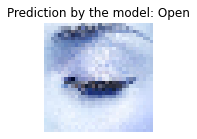

In [59]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

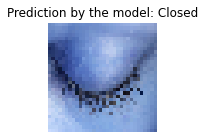

In [60]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

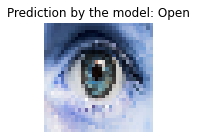

In [61]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

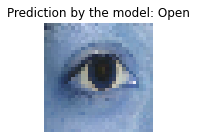

In [62]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()

In [ ]:
!deepCC Driver_Drowsiness_Detection.h5